In [13]:
import os
import numpy as np
from glob import glob
import cv2
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_H = 64
IMG_W = 64
IMG_C = 3

w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (IMG_H, IMG_W))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    return image

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def deconvo_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(filters=num_filters, kernel_size = kernel_size, kernel_initializer=w_init, padding="same", strides=strides,use_bias=False)(inputs)
    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x

def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(filters=num_filters, kernel_size = kernel_size, kernel_initializer=w_init, padding=padding, strides=strides)(inputs)
    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    noise = Input(shape=(latent_dim,), name="gen_noise_input")

    x = Dense(f[0]*filters*h_output*w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, f[0]*filters))(x)

    for i in range(1,5):
        x = deconvo_block(x, num_filters=f[i]*filters, kernel_size=5, strides=2,bn=True)

    x = conv_block(x, num_filters = 3, kernel_size=5, strides=1, activation=False)
    fake_output = Activation("tanh")(x)
    return Model(noise, fake_output, name="generator")

def build_discriminator():
    f = [2**i for i in range(4)]
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    image_input = Input(shape=(IMG_H, IMG_W, IMG_C), name="images")
    x = image_input

    for i in range(0,4):
        x = conv_block(x, num_filters=f[i]*filters, kernel_size=5, strides=2)
    x = Flatten()(x)
    x = Dense(1)(x)
    return Model(image_input, x, name="discriminator")

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as stape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = stape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss":d2_loss, "g_loss": g_loss}


In [14]:
batch_size = 128
latent_dim = 128
num_epochs = 50

images_path = glob("/kaggle/input/animefaces/data/*")

d_model = build_discriminator()
g_model = build_generator(latent_dim)

d_model.summary()
g_model.summary()

gan = GAN(d_model, g_model, latent_dim)

bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

images_dataset = tf_dataset(images_path, batch_size)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_34 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_35 (LeakyReLU)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gen_noise_input (InputLayer)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8192)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_36 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 8, 8, 256)           │       3,276,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_37 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 16, 16, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_38 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 32, 32, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_39 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 64, 64, 32)          │          51,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_40 (LeakyReLU)           │ (None, 64, 64, 32)          │              

 Total params: 5,437,667 (20.74 MB)

 Trainable params: 5,420,323 (20.68 MB)

 Non-trainable params: 17,344 (67.75 KB)

In [15]:
gan.fit(images_dataset, epochs = num_epochs)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 444ms/step - d1_loss: 0.2363 - d2_loss: 0.2172 - g_loss: 2.7826
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - d1_loss: 0.2174 - d2_loss: 0.2167 - g_loss: 3.0761
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 386ms/step - d1_loss: 0.2123 - d2_loss: 0.2166 - g_loss: 3.0254
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 387ms/step - d1_loss: 0.2110 - d2_loss: 0.2136 - g_loss: 2.9839
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step - d1_loss: 0.2169 - d2_loss: 0.2171 - g_loss: 2.9616
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - d1_loss: 0.2136 - d2_loss: 0.2146 - g_loss: 2.9998
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 387ms/step - d1_loss: 0.2161 - d2_loss: 0.2149 - g_loss: 3.0592
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step - d1_loss: 0.2171 - d2_loss: 0.2166 - g_loss: 3.0611
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 386ms/step - d1_loss: 0.2178 - d2_loss: 0.2147 - g_loss: 3.0734
Epoch 10/50
169/169 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


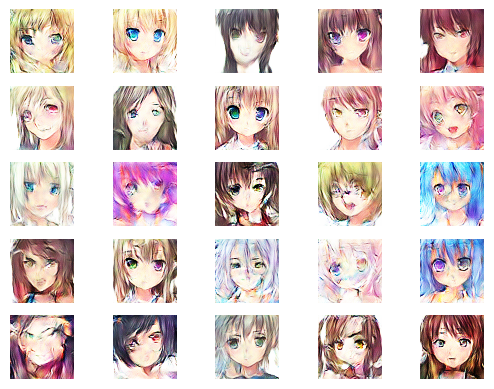

In [16]:
def show_plot(examples, n):
    examples = (examples +1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])

n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = g_model.predict(latent_points)
show_plot(examples, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


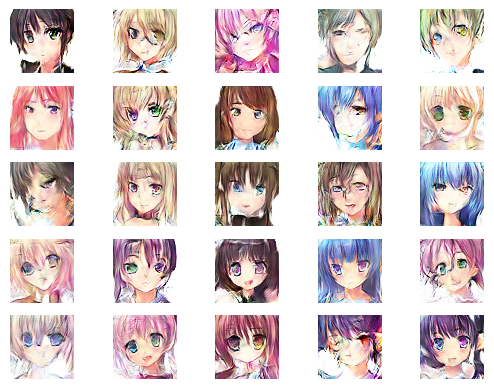

In [17]:
def show_plot(examples, n):
    examples = (examples +1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])

n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = g_model.predict(latent_points)
show_plot(examples, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


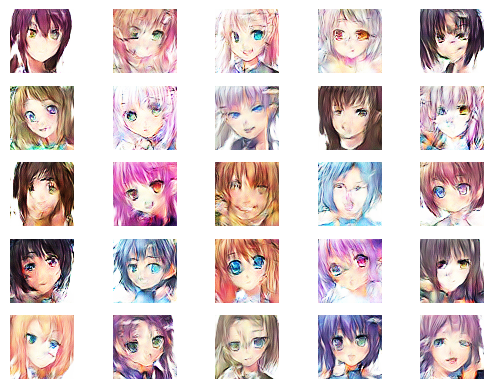

In [18]:
def show_plot(examples, n):
    examples = (examples +1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])

n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = g_model.predict(latent_points)
show_plot(examples, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


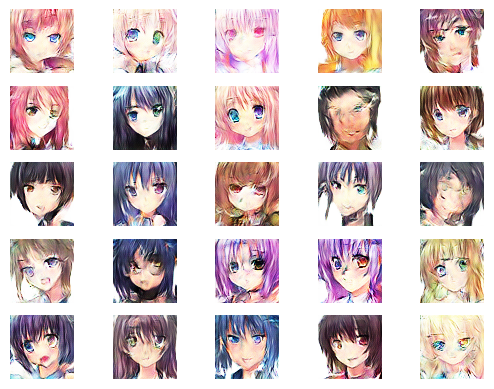

In [19]:
def show_plot(examples, n):
    examples = (examples +1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])

n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = g_model.predict(latent_points)
show_plot(examples, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


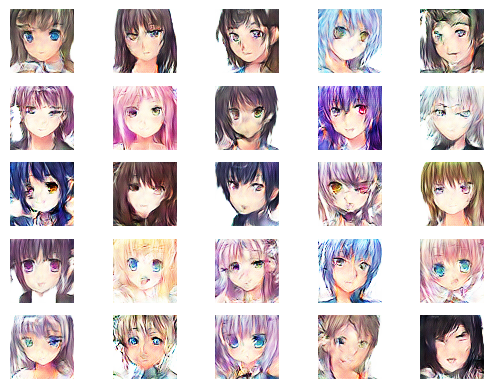

In [20]:
def show_plot(examples, n):
    examples = (examples +1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.axis("off")
        plt.imshow(examples[i])

n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = g_model.predict(latent_points)
show_plot(examples, 5)